# Local Outlier Factor (LOF)
Unsupervised Outlier Detection using Local Outlier Factor (LOF). The anomaly score of each sample is called Local Outlier Factor. It measures the local deviation of density of a given sample with respect to its neighbors. It is local in that the anomaly score depends on how isolated the object is with respect to the surrounding neighborhood. More precisely, locality is given by k-nearest neighbors, whose distance is used to estimate the local density. By comparing the local density of a sample to the local densities of its neighbors, one can identify samples that have a substantially lower density than their neighbors. These are considered outliers.

### Import required libraries/modules

In [1]:
%matplotlib inline
import numpy as np
import pandas as pd
import scipy as sp
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.neighbors import LocalOutlierFactor
from sklearn.preprocessing import StandardScaler, MinMaxScaler, Normalizer
from sklearn.metrics import roc_auc_score,confusion_matrix,f1_score, roc_curve, auc, accuracy_score, precision_score, recall_score
from collections import Counter

We are going to work with HTTP access data from an open dataset from the KDD Cup '99, which consists of millions of network accesses containing multiple different types of attacks (alongside normal accesses) from a simulated military network. You can get the dataset from http://kdd.ics.uci.edu/databases/kddcup99/kddcup99.html. We're using the 10 percent set containing a little under half a million datapoints and 3 (of 41) features (columns) that are relevant for HTTP requests.

### Load the data

In [2]:
kdd = pd.read_csv('data/kddcup.data_10_percent_corrected.csv')

In [3]:
print(kdd.head())

   duration protocol_type service flag  src_bytes  dst_bytes  land  \
0         0           tcp    http   SF        181       5450     0   
1         0           tcp    http   SF        239        486     0   
2         0           tcp    http   SF        235       1337     0   
3         0           tcp    http   SF        219       1337     0   
4         0           tcp    http   SF        217       2032     0   

   wrong_fragment  urgent  hot   ...     dst_host_srv_count  \
0               0       0    0   ...                      9   
1               0       0    0   ...                     19   
2               0       0    0   ...                     29   
3               0       0    0   ...                     39   
4               0       0    0   ...                     49   

   dst_host_same_srv_rate  dst_host_diff_srv_rate  \
0                     1.0                     0.0   
1                     1.0                     0.0   
2                     1.0                

### Filter the data

We would like to look at only the logged-in HTTP accesses from the data

In [4]:
kdd.dtypes

duration                         int64
protocol_type                   object
service                         object
flag                            object
src_bytes                        int64
dst_bytes                        int64
land                             int64
wrong_fragment                   int64
urgent                           int64
hot                              int64
num_failed_logins                int64
logged_in                        int64
num_compromised                  int64
root_shell                       int64
su_attempted                     int64
num_root                         int64
num_file_creations               int64
num_shells                       int64
num_access_files                 int64
num_outbound_cmds                int64
is_host_login                    int64
is_guest_login                   int64
count                            int64
srv_count                        int64
serror_rate                    float64
srv_serror_rate          

In [5]:
kdd = kdd[kdd.service=='http']

In [6]:
kdd.service.unique()

array(['http'], dtype=object)

In [7]:
kdd = kdd[kdd.logged_in==1]

In [8]:
kdd.logged_in.unique()

array([1], dtype=int64)

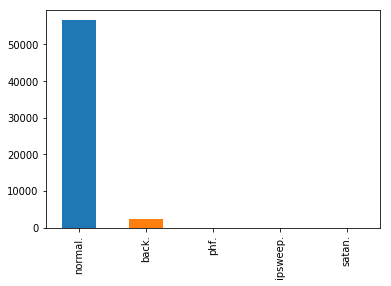

In [9]:
kdd.label.value_counts().plot(kind='bar')

### Relevant Feature Selection
The full dataset contains 41 features with data relating to TCP packets, SMTP access, etc. but only 3 of those are relevant for HTTP. We need to extract those 3 features so we are not training with irrelevant features that will add noise to our model. Also, SVM implementations work better with normalised data. This yields both better accuracy and reduces numerical instability that is inherent in their implementation.

In [10]:
features = ['duration','src_bytes','dst_bytes','label']
kdd = kdd[features]

In [11]:
kdd.dtypes

duration      int64
src_bytes     int64
dst_bytes     int64
label        object
dtype: object

In [12]:
print(kdd.describe())

           duration     src_bytes     dst_bytes
count  58725.000000  58725.000000  5.872500e+04
mean       0.686641   2282.454593  4.658200e+03
std       14.394064  10259.946866  1.982101e+04
min        0.000000      0.000000  0.000000e+00
25%        0.000000    218.000000  6.860000e+02
50%        0.000000    253.000000  1.724000e+03
75%        0.000000    309.000000  5.053000e+03
max     1440.000000  54540.000000  3.916592e+06


In [13]:
#kdd_scaled = kdd
#kdd_scaled["duration"] = np.log((kdd["duration"] + 0.1).astype(float))  
#kdd_scaled["src_bytes"] = np.log((kdd["src_bytes"] + 0.1).astype(float))  
#kdd_scaled["dst_bytes"] = np.log((kdd["dst_bytes"] + 0.1).astype(float)) 

Normal(inlier) is labelled with 1 and abnormal(outlier) is labelled with -1

In [14]:
kdd['attack'] = np.where(kdd['label']=='normal.',1,-1)

In [15]:
frac = Counter(kdd.attack)
print(frac)

Counter({1: 56516, -1: 2209})


In [16]:
print('Outliers fraction:', round(list(frac.values())[1]/(list(frac.values())[0]+list(frac.values())[1]),2))

Outliers fraction: 0.04


In [17]:
kdd.dtypes

duration      int64
src_bytes     int64
dst_bytes     int64
label        object
attack        int32
dtype: object

In [18]:
kdd.label.unique()

array(['normal.', 'ipsweep.', 'back.', 'phf.', 'satan.'], dtype=object)

In [19]:
kdd.attack.unique()

array([ 1, -1], dtype=int64)

In [20]:
X_train, X_test, y_train, y_test = train_test_split(kdd.iloc[:, 0:3],kdd['attack'], test_size=0.2, random_state=2018)

In [21]:
print('Sneak peek at the Training Data: \n' ,X_train.head())
print('Shape of Training Data:',X_train.shape)
print('Shape of Training Labels:',y_train.shape)
print('Shape of Test Data:',X_test.shape)
print('Shape of Test Labels:',y_test.shape)

Sneak peek at the Training Data: 
         duration  src_bytes  dst_bytes
492218         0        339       3090
492677         0        284       3656
21093          0        339        250
32631          0        201       4841
176            0        212      24572
Shape of Training Data: (46980, 3)
Shape of Training Labels: (46980,)
Shape of Test Data: (11745, 3)
Shape of Test Labels: (11745,)


In [22]:
print(Counter(y_train))
print(Counter(y_test))

Counter({1: 45217, -1: 1763})
Counter({1: 11299, -1: 446})


In [23]:
train_error = []

# Calculating error for K values between 1 and 40
for i in range(1, 50):  
    lof = LocalOutlierFactor(n_neighbors=i, n_jobs=-1)
    lof.fit(X_train)
    pred_i = lof.fit_predict(X_train)
    train_error.append(np.mean(pred_i != y_train))

Text(0,0.5,'Training Error')

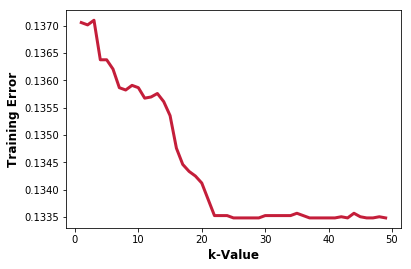

In [24]:
plt.plot(range(1, 50), train_error, color='#c41e3a', linestyle='-',linewidth=3)
plt.xlabel('k-Value', fontsize=12, fontweight='bold')  
plt.ylabel('Training Error', fontsize=12, fontweight='bold') 

In [25]:
test_error = []

# Calculating error for K values between 1 and 40
for i in range(1, 50):  
    lof = LocalOutlierFactor(n_neighbors=i, n_jobs=-1)
    lof.fit(X_train)
    pred_i = lof.fit_predict(X_test)
    test_error.append(np.mean(pred_i != y_test))

Text(0,0.5,'Validation Error')

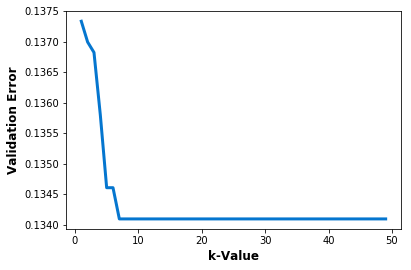

In [26]:
plt.plot(range(1, 50), test_error, color='#0576cf', linestyle='-',linewidth=3)
plt.xlabel('k-Value', fontsize=12, fontweight='bold')  
plt.ylabel('Validation Error', fontsize=12, fontweight='bold') 

Text(0,0.5,'Training Error')

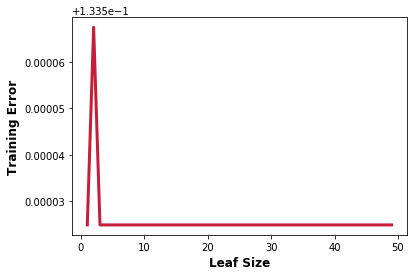

In [27]:
train_error = []

# Calculating error for K values between 1 and 40
for i in range(1, 50):  
    lof = LocalOutlierFactor(leaf_size=i, n_jobs=-1, n_neighbors=30)
    lof.fit(X_train)
    pred_i = lof.fit_predict(X_train)
    train_error.append(np.mean(pred_i != y_train))
    
plt.plot(range(1, 50), train_error, color='#c41e3a', linestyle='-',linewidth=3)
plt.xlabel('Leaf Size', fontsize=12, fontweight='bold')  
plt.ylabel('Training Error', fontsize=12, fontweight='bold') 

Text(0,0.5,'Validation Error')

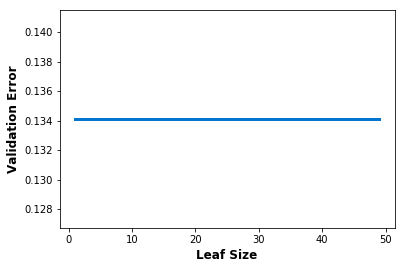

In [28]:
test_error = []

# Calculating error for K values between 1 and 40
for i in range(1, 50):  
    lof = LocalOutlierFactor(leaf_size=i, n_jobs=-1, n_neighbors=30)
    lof.fit(X_train)
    pred_i = lof.fit_predict(X_test)
    test_error.append(np.mean(pred_i != y_test))

plt.plot(range(1, 50), test_error, color='#0576cf', linestyle='-',linewidth=3)
plt.xlabel('Leaf Size', fontsize=12, fontweight='bold')  
plt.ylabel('Validation Error', fontsize=12, fontweight='bold')

Text(0,0.5,'Training Error')

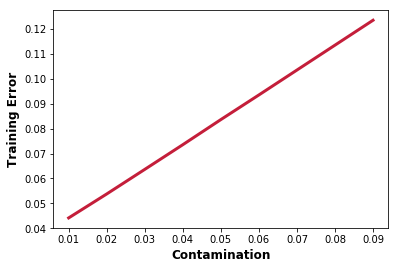

In [29]:
train_error = []

# Calculating error for K values between 1 and 40
for i in np.arange(0.01, 0.1, 0.01):  
    lof = LocalOutlierFactor(contamination=i, n_jobs=-1, n_neighbors=30, leaf_size=10)
    lof.fit(X_train)
    pred_i = lof.fit_predict(X_train)
    train_error.append(np.mean(pred_i != y_train))
    
plt.plot(np.arange(0.01, 0.1, 0.01), train_error, color='#c41e3a', linestyle='-',linewidth=3)
plt.xlabel('Contamination', fontsize=12, fontweight='bold')  
plt.ylabel('Training Error', fontsize=12, fontweight='bold') 

Text(0,0.5,'Validation Error')

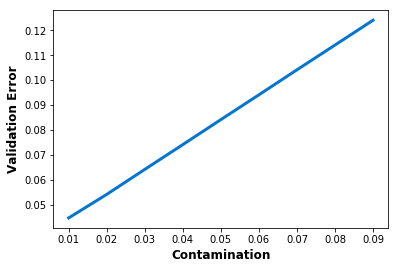

In [30]:
test_error = []

# Calculating error for K values between 1 and 40
for i in np.arange(0.01, 0.1, 0.01):  
    lof = LocalOutlierFactor(contamination=i, n_jobs=-1, n_neighbors=30, leaf_size=10)
    lof.fit(X_train)
    pred_i = lof.fit_predict(X_test)
    test_error.append(np.mean(pred_i != y_test))

plt.plot(np.arange(0.01, 0.1, 0.01), test_error, color='#0576cf', linestyle='-',linewidth=3)
plt.xlabel('Contamination', fontsize=12, fontweight='bold')  
plt.ylabel('Validation Error', fontsize=12, fontweight='bold')

### Fit the Local Outlier Factor Model on the Training Data without Labels

In [31]:
lof = LocalOutlierFactor(n_neighbors=30, algorithm='auto', leaf_size=10, 
                   metric='minkowski', p=2, metric_params=None, contamination=0.01, n_jobs=-1)
lof.fit(X_train)

LocalOutlierFactor(algorithm='auto', contamination=0.01, leaf_size=10,
          metric='minkowski', metric_params=None, n_jobs=-1,
          n_neighbors=30, p=2)

In [32]:
lof.threshold_

-2.490971635687488

In [33]:
print(Counter(lof.fit_predict(X_train)))
print(Counter(lof.fit_predict(X_test)))

Counter({1: 46510, -1: 470})
Counter({1: 11621, -1: 124})


In [34]:
lof.negative_outlier_factor_

array([-1.05264388, -1.00109182, -1.05418341, ..., -1.10070156,
       -0.99643798, -0.98108686])

In [35]:
lof.fit(X_train)
print(lof.threshold_)

-2.49097163569


In [36]:
lof.fit(X_test)
print(lof.threshold_)

-2.30250787839


### Predict the Anomaly Scores
We can get the anomaly score of the input samples. <b>The lower, the more abnormal.</b>

In [37]:
lof.fit(X_train)
y_train_anomaly_score = lof.negative_outlier_factor_
threshold_train = lof.threshold_
lof.fit(X_test)
y_test_anomaly_score = lof.negative_outlier_factor_
threshold_test = lof.threshold_

In [38]:
np.percentile(y_train_anomaly_score, 0.95)

-2.5494956279094523

In [39]:
y_train_score = np.where(y_train_anomaly_score<=np.percentile(y_train_anomaly_score, 0.95), -1, 1)
y_test_score = np.where(y_test_anomaly_score<=np.percentile(y_test_anomaly_score, 0.95), -1, 1)
print(Counter(y_train_score))
print(Counter(y_test_score))

Counter({1: 46533, -1: 447})
Counter({1: 11633, -1: 112})


In [40]:
print(sp.stats.describe(y_train_anomaly_score))
print(sp.stats.describe(y_test_anomaly_score))

DescribeResult(nobs=46980, minmax=(-24392797628658.691, -0.90677434328641793), mean=-4036667551.5211167, variance=4.0700120307702002e+22, skewness=-85.02901550268804, kurtosis=9333.528385273847)
DescribeResult(nobs=11745, minmax=(-110667063501805.09, -0.93965974747950776), mean=-45845537360.203255, variance=3.0415116714976012e+24, skewness=-46.99379987398764, kurtosis=2442.9903063813563)


### Predict the labels (outlier or inlier)
Predict if a particular sample is an outlier or not. For each observation, tells whether or not (+1 or -1) it should be considered as an inlier according to the fitted model.

In [41]:
y_pred_train = lof.fit_predict(X_train)
y_pred_test = lof.fit_predict(X_test)

In [42]:
print(Counter(y_train))
print(Counter(y_test))
print(Counter(y_pred_train))
print(Counter(y_pred_test))

Counter({1: 45217, -1: 1763})
Counter({1: 11299, -1: 446})
Counter({1: 46510, -1: 470})
Counter({1: 11621, -1: 124})


### Evaluation metrics for Training data

In [43]:
print("Accuracy: ", accuracy_score(y_train, y_pred_train))  
print("Precision: ", precision_score(y_train, y_pred_train))  
print("Recall: ", recall_score(y_train, y_pred_train))  
print("f1 Score: ", f1_score(y_train, y_pred_train))  
print("Area Under the ROC (AUC): ", roc_auc_score(y_train, y_pred_train))

Accuracy:  0.955874840358
Precision:  0.963814233498
Recall:  0.99137492536
f1 Score:  0.977400329238
Area Under the ROC (AUC):  0.518376061659


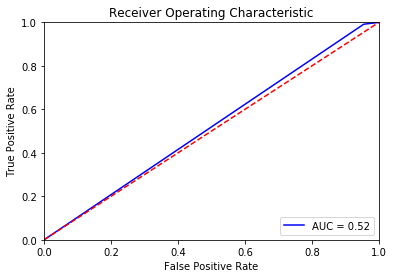

In [44]:
fpr, tpr, thresholds = roc_curve(y_train, y_pred_train)
roc_auc = auc(fpr, tpr)
plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

### Evaluation metrics for Test data

In [45]:
print("Accuracy: ", accuracy_score(y_test, y_pred_test))  
print("Precision: ", precision_score(y_test, y_pred_test))  
print("Recall: ", recall_score(y_test, y_pred_test))  
print("f1 Score: ", f1_score(y_test, y_pred_test))  
print("Area Under the ROC (AUC): ", roc_auc_score(y_test, y_pred_test))

Accuracy:  0.955385270328
Precision:  0.963600378625
Recall:  0.991061155855
f1 Score:  0.977137870855
Area Under the ROC (AUC):  0.52131533129


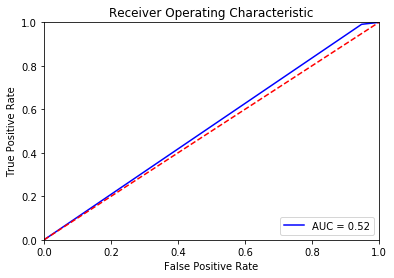

In [46]:
fpr, tpr, thresholds = roc_curve(y_test, y_pred_test)
roc_auc = auc(fpr, tpr)
plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

In [47]:
confmat_train = confusion_matrix(y_train, y_pred_train)
confmat_test = confusion_matrix(y_test, y_pred_test)

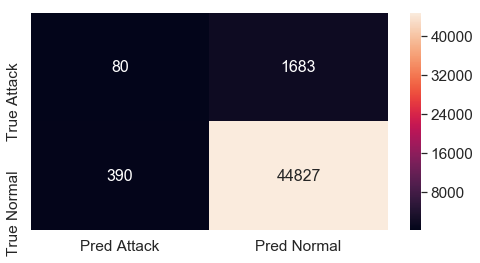

In [48]:
import seaborn as sns
confmat_train = pd.DataFrame(confmat_train,
                  ['True Attack','True Normal'],['Pred Attack','Pred Normal'])
plt.figure(figsize = (8,4))
sns.set(font_scale=1.4)# for label size
sns.heatmap(confmat_train, annot=True, annot_kws={"size": 16},fmt='g')

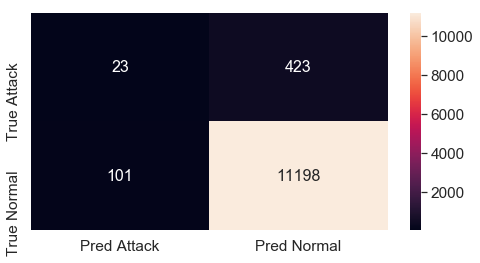

In [49]:
import seaborn as sns
confmat_train = pd.DataFrame(confmat_test,
                  ['True Attack','True Normal'],['Pred Attack','Pred Normal'])
plt.figure(figsize = (8,4))
sns.set(font_scale=1.4)# for label size
sns.heatmap(confmat_train, annot=True, annot_kws={"size": 16},fmt='g')